# Customer Churn Prediction with Machine Learning

- **Dataset**:  
  &nbsp;&nbsp;&nbsp;We are using the *Telco Customer Churn Dataset* from Kaggle with **7000+ records** for intensive study.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Basic exploration
print("Dataset Shape:", df.shape)
print("\nColumn Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (7043, 21)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Pa

### Exploratory Data Analysis

#### Clean and preprocess

In [5]:
# Convert TotalCharges to numeric (fix strings)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    median_total = df['TotalCharges'].median()
    df['TotalCharges'] = df['TotalCharges'].fillna(median_total)

# Convert target to binary
df['Churn_Binary'] = df['Churn'].map({'Yes': 1, 'No': 0})


#### Churn Rate & Simple Visuals

Churned: 1,869, Stayed: 5,174
Overall Churn Rate: 26.54%


/var/folders/qj/h9pcnm497f3fht3l3qw6v5rw0000gn/T/ipykernel_43278/1702813465.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn', palette=['lightgreen','lightcoral'])


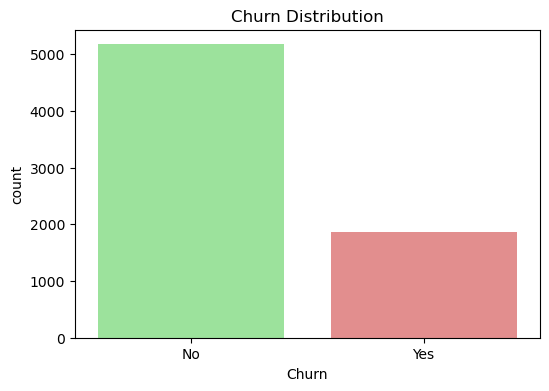

In [7]:
# Churn rate
churn_counts = df['Churn'].value_counts()
churn_rate = (churn_counts.get('Yes',0) / len(df)) * 100
print(f"Churned: {churn_counts.get('Yes',0):,}, Stayed: {churn_counts.get('No',0):,}")
print(f"Overall Churn Rate: {churn_rate:.2f}%")

# Simple countplot
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn', palette=['lightgreen','lightcoral'])
plt.title('Churn Distribution')
plt.show()


#### Feature Correlations & Analysis

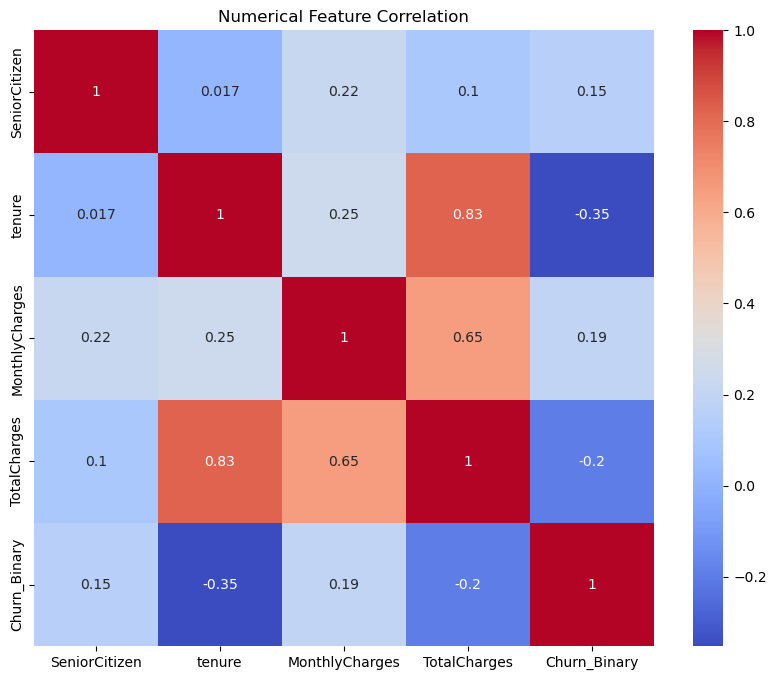

In [9]:
# Numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')

# Correlation matrix (numeric only)
plt.figure(figsize=(10,8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Numerical Feature Correlation')
plt.show()


#### Categorical Feature Analysis

Categorical columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


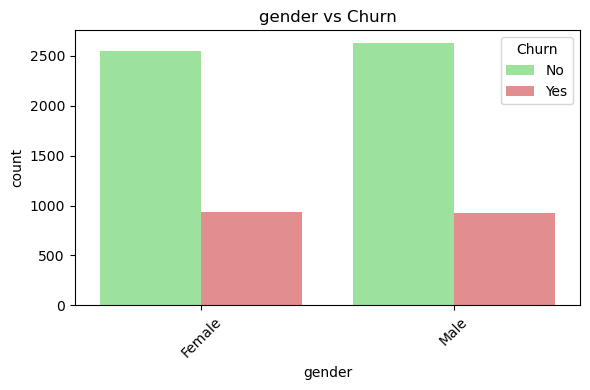

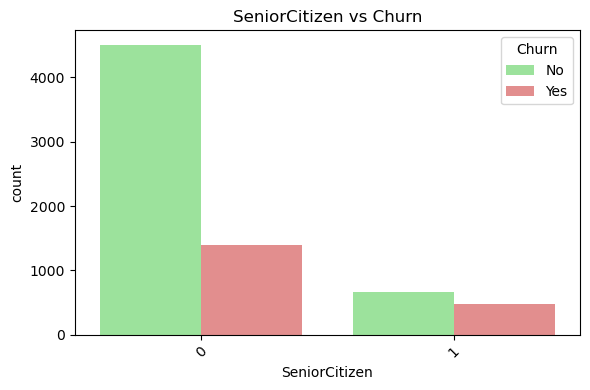

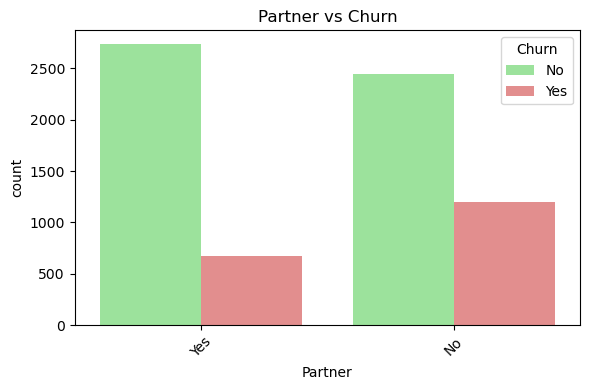

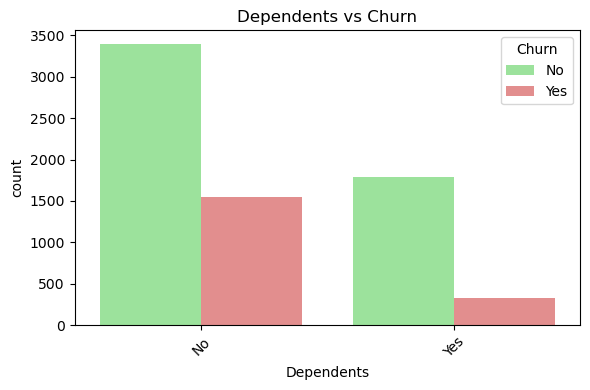

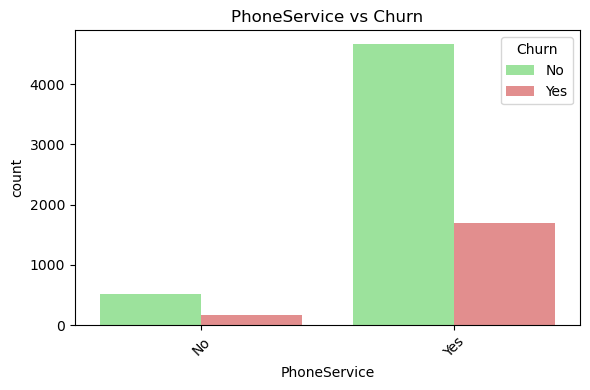

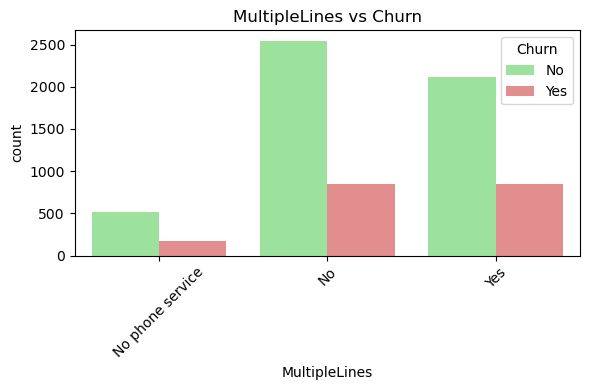

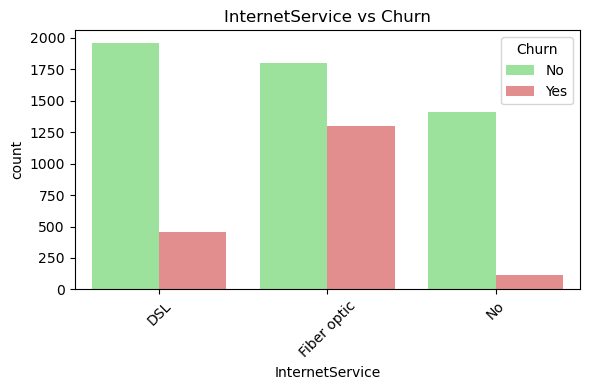

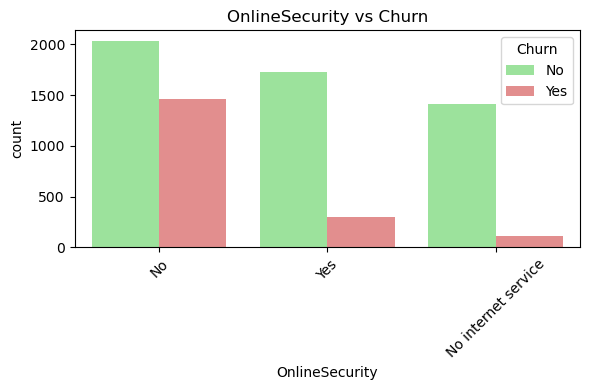

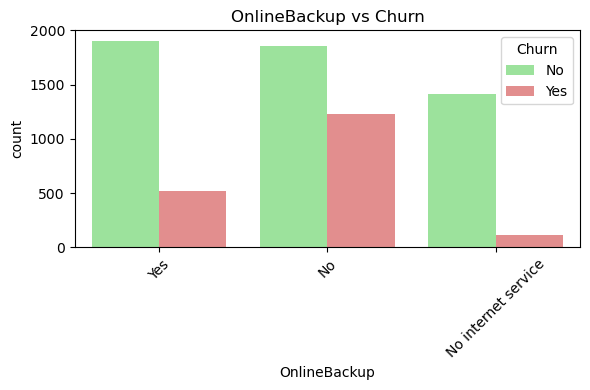

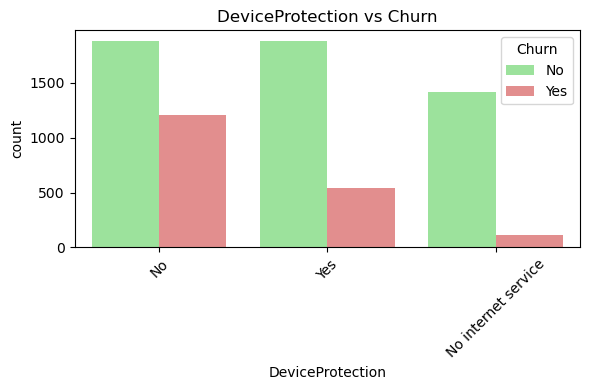

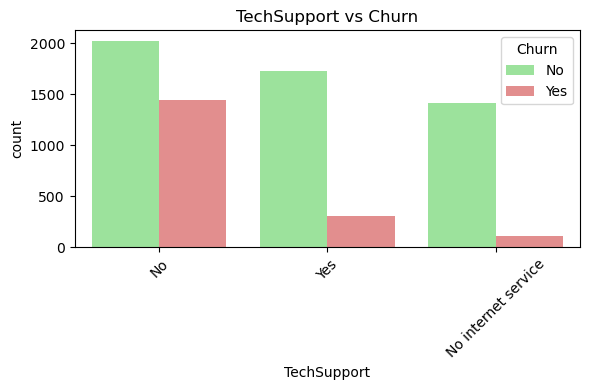

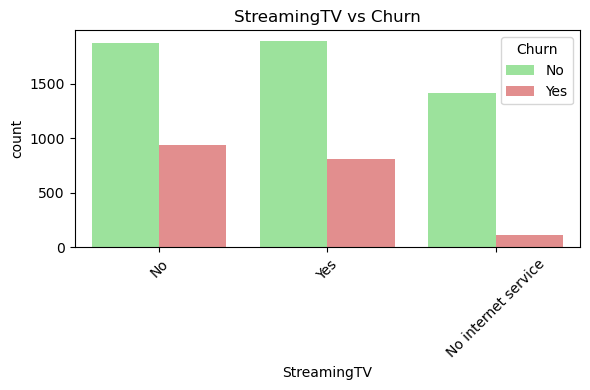

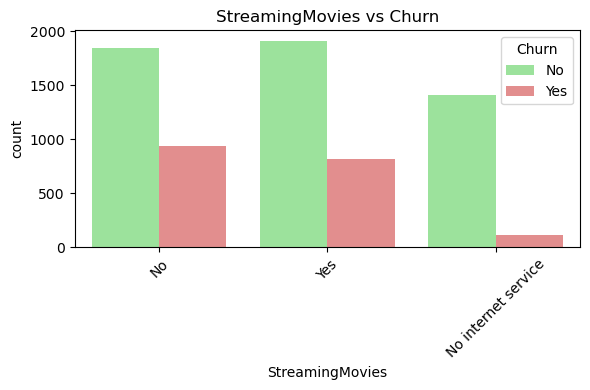

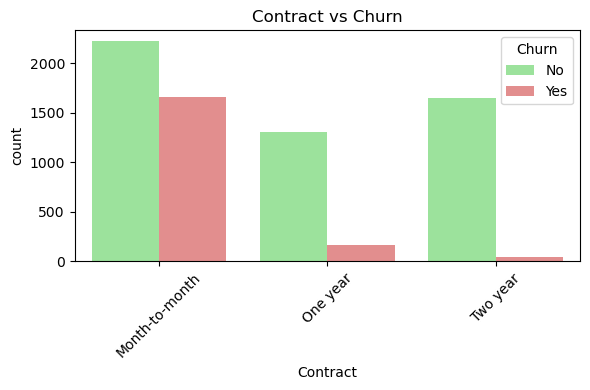

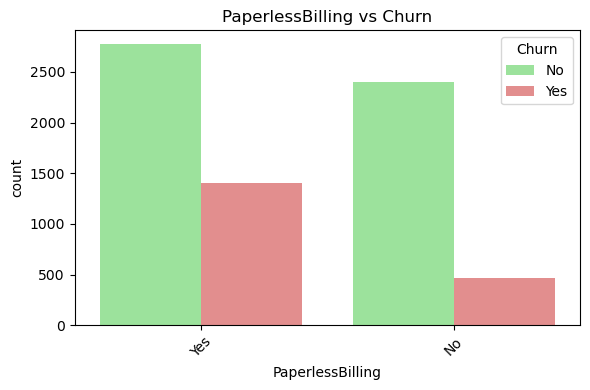

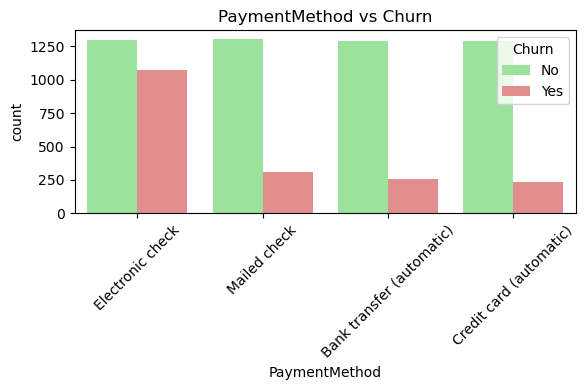

In [11]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)
# 1. Define categorical columns
cat_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                'PhoneService', 'MultipleLines', 'InternetService',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies',
                'Contract', 'PaperlessBilling', 'PaymentMethod']
cat_features = [col for col in cat_features if col in df.columns]

# 2. Plot categorical features vs Churn
for col in cat_features:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue='Churn', palette=['lightgreen','lightcoral'])
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Data Preprocessing

#### Handle Missing Values

In [14]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Handle missing values (if any)
df = df.dropna()  # or use fillna() for imputation

Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
Churn_Binary        0
dtype: int64


#### Convert Data Types

In [16]:
# Convert TotalCharges to numeric (it might be stored as string)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Convert target variable to binary
# Keep original Churn column, don't overwrite it
# df['Churn_Binary'] is already created correctly above
pass  # Remove the line that overwrites Churn

#### Feature Engineering

In [18]:
# Create new features
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], 
                           labels=['0-1 year', '1-2 years', '2-4 years', '4+ years'])

df['avg_monthly_charges'] = np.where(
    df['tenure'] > 0,
    df['TotalCharges'] / df['tenure'],
    df['MonthlyCharges']
)

#### Encode Categorical Variables

In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# For binary categorical variables
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# For multi-category variables (use one-hot encoding)
multi_cols = ['InternetService', 'Contract', 'PaymentMethod']
df_encoded = pd.get_dummies(df, columns=multi_cols, drop_first=True)

### Feature Selection

#### Select Relevant Features

In [23]:
import numpy as np
import pandas as pd

# Ensure Churn_Binary is numeric
df_encoded['Churn_Binary'] = pd.to_numeric(df_encoded['Churn_Binary'], errors='coerce')

# Drop rows where target is NaN
df_encoded = df_encoded.dropna(subset=['Churn_Binary'])

# Separate features and target
X = df_encoded.drop(columns=['customerID', 'Churn'], errors='ignore')
y = df_encoded['Churn_Binary']

# Convert all categorical columns in X to numeric (as int)
for col in X.select_dtypes(['category', 'object']).columns:
    X[col] = pd.factorize(X[col])[0].astype(int)

# Replace infinite values and fill remaining NaNs
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"Shape of X: {X.shape}")
print(f"Number of NaNs in y: {y.isna().sum()}")
print(f"Any remaining NaNs in X? {X.isna().sum().sum()}")


Shape of X: (7043, 26)
Number of NaNs in y: 0
Any remaining NaNs in X? 0


#### Feature Importance Analysis

In [25]:
# Convert 'Churn' column from 'Yes'/'No' to integer 1/0
df['Churn_Binary'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Verify
print(df['Churn_Binary'].unique())
print(df['Churn_Binary'].value_counts())


[0 1]
Churn_Binary
0    5174
1    1869
Name: count, dtype: int64


In [26]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# For binary categorical variables
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# For multi-category variables (use one-hot encoding)
multi_cols = ['InternetService', 'Contract', 'PaymentMethod']
df_encoded = pd.get_dummies(df, columns=multi_cols, drop_first=True)


In [27]:
# Drop non-feature columns (ID, original target) and make sure all features are numeric
X = pd.get_dummies(
    df.drop(columns=['Churn', 'Churn_Binary', 'customerID'], errors='ignore'),
    drop_first=True
)

# Target variable
y = df['Churn_Binary']

print("Shape of X:", X.shape)
print("Any NaNs in X?", X.isna().sum().sum())
print("Any NaNs in y?", y.isna().sum())


Shape of X: (7043, 34)
Any NaNs in X? 0
Any NaNs in y? 0


In [28]:
print("NaNs in X:", X.isna().sum().sum())
print("Infs in X:", np.isinf(X).sum().sum())
print("Max value in X:", X.max().max())
print("Min value in X:", X.min().min())


NaNs in X: 0
Infs in X: 0
Max value in X: 8684.8
Min value in X: 0


In [29]:
# Replace infinities with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Fill NaN with 0 (or you can use column mean/median instead)
X = X.fillna(0)


In [30]:
print("NaNs in X:", X.isna().sum().sum())
print("Infs in X:", np.isinf(X).sum().sum())


NaNs in X: 0
Infs in X: 0


In [31]:
# Define the model BEFORE using it
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist,
    n_iter=20, cv=5, verbose=2, n_jobs=-1, random_state=42
)

random_search.fit(X, y)

best_rf = random_search.best_estimator_   # 👈 now best_rf exists


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [33]:

import numpy as np
import pandas as pd

def make_features(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()

    # Ensure numeric types for key numeric columns
    df['tenure'] = pd.to_numeric(df.get('tenure'), errors='coerce').fillna(0)
    df['MonthlyCharges'] = pd.to_numeric(df.get('MonthlyCharges'), errors='coerce').fillna(0)
    df['TotalCharges'] = pd.to_numeric(df.get('TotalCharges'), errors='coerce').fillna(0)

    # Collapse "No internet service"/"No phone service" to "No" so dummies match training
    df = df.replace({'No internet service': 'No', 'No phone service': 'No'})

    # Create engineered features exactly as in training
    df['tenure_group'] = pd.cut(
        df['tenure'],
        bins=[-0.1, 12, 24, 48, 1000],
        labels=['0-1 year', '1-2 years', '2-4 years', '4+ years']
    )

    # Avoid inf/NaN in division
    avg = df['TotalCharges'] / df['tenure'].replace(0, np.nan)
    df['avg_monthly_charges'] = avg.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Use the same feature columns you modeled on in Cell 19
    base_cols = [
        'Dependents','tenure','PhoneService','MultipleLines','InternetService',
        'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
        'StreamingTV','StreamingMovies','Contract','PaperlessBilling',
        'PaymentMethod','MonthlyCharges','TotalCharges','tenure_group','avg_monthly_charges'
    ]

    # Some uploaded files may miss a few columns; create them if missing
    for c in base_cols:
        if c not in df.columns:
            df[c] = np.nan

    X = df[base_cols].copy()
    X = pd.get_dummies(X, drop_first=True)  # ONE-HOT just like training
    return X

def make_target(df_in: pd.DataFrame) -> pd.Series:
    # Be robust: accept 'Yes'/'No' OR '1'/'0'
    return (df_in['Churn']
            .map({'No': 0, 'Yes': 1, '0': 0, '1': 1})
            .astype(int))


In [34]:
# Build X and y with the shared functions
X = make_features(df)
y = make_target(df)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ... keep your RandomForest + GridSearch code ...
# best_rf = GridSearchCV(...); best_rf.fit(X_train, y_train)

best_rf.fit(X_train, y_train)  # (if you already have best_rf defined above)

# === SAVE MODEL + TRAINING COLUMNS (NEW) ===
import joblib
joblib.dump(best_rf, 'rf_model.pkl')
joblib.dump(list(X.columns), 'model_features.pkl')  # <-- critical for Streamlit alignment
print("✅ Saved rf_model.pkl and model_features.pkl")


✅ Saved rf_model.pkl and model_features.pkl


In [35]:
!ls -lh


total 24272
-rw-r--r--  1 TonysJarvis  staff   653K Aug 20 22:15 Customer Churn Prediction.ipynb
-rw-r--r--  1 TonysJarvis  staff   2.4K Aug 20 22:16 Customer_Churn_Prediction.py
drwxr-xr-x  3 TonysJarvis  staff    96B Aug 18 05:56 data
-rw-r--r--  1 TonysJarvis  staff   534B Aug 20 22:16 model_features.pkl
-rw-r--r--  1 TonysJarvis  staff    11M Aug 20 22:16 rf_model.pkl


In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Feature importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(20))


TotalCharges                             0.171901
avg_monthly_charges                      0.152262
MonthlyCharges                           0.150694
tenure                                   0.139126
InternetService_Fiber optic              0.042616
PaymentMethod_Electronic check           0.040521
Contract_Two year                        0.033054
PaperlessBilling                         0.024255
Contract_One year                        0.023155
tenure_group_4+ years                    0.022472
TechSupport_Yes                          0.019936
Dependents                               0.019841
OnlineSecurity_Yes                       0.019731
OnlineBackup_Yes                         0.018339
MultipleLines_Yes                        0.017765
DeviceProtection_Yes                     0.016942
InternetService_No                       0.014983
StreamingMovies_Yes                      0.014295
StreamingTV_Yes                          0.013719
PaymentMethod_Credit card (automatic)    0.012166


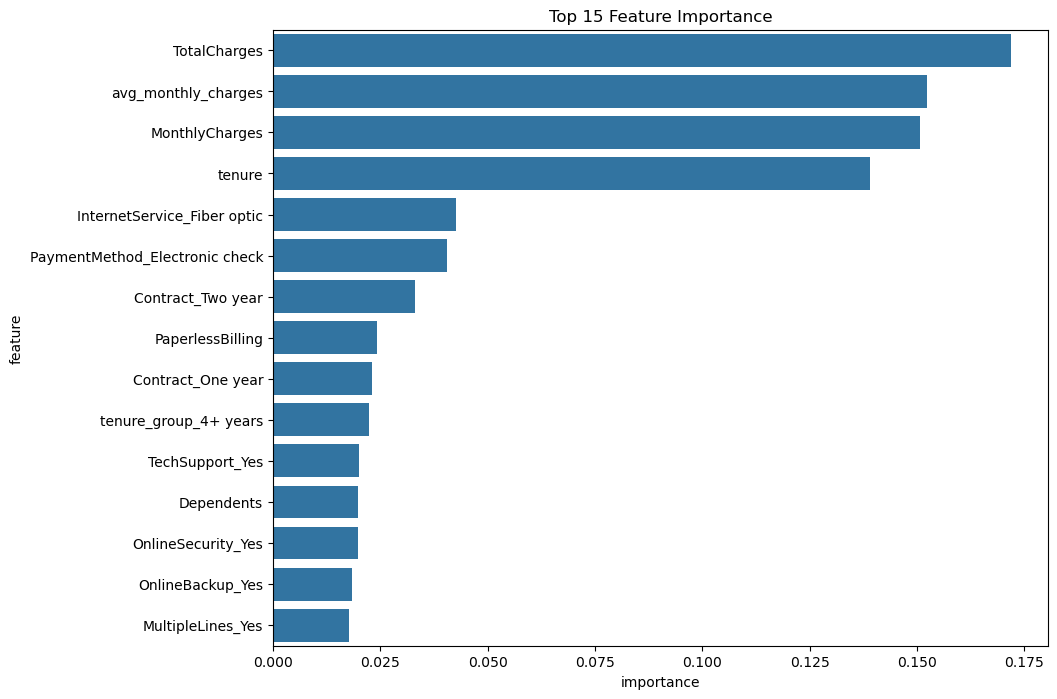

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2

# Quick feature importance using Random Forest
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X, y)

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), y='feature', x='importance')
plt.title('Top 15 Feature Importance')
plt.show()

###  Model Building 

#### Split the data

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (5634, 24)
Test set size: (1409, 24)


#### Build Multiple Models

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# 2. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # RF doesn't need scaling
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

#### Model Evaluation


=== Logistic Regression Results ===
Accuracy: 0.8006
Precision: 0.6535
Recall: 0.5294
F1-Score: 0.5849
AUC-ROC: 0.8410


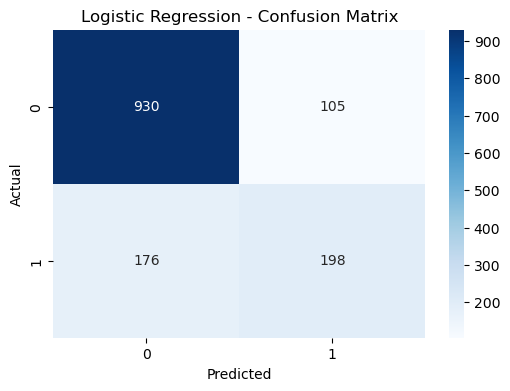


=== Random Forest Results ===
Accuracy: 0.7814
Precision: 0.6078
Recall: 0.4973
F1-Score: 0.5471
AUC-ROC: 0.8165


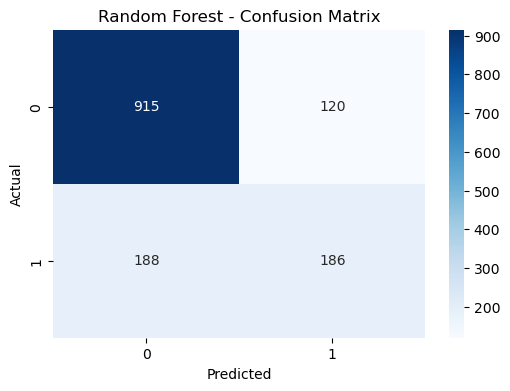

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    print(f"\n=== {model_name} Results ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, y_pred_proba):.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Evaluate both models
evaluate_model(y_test, lr_pred, lr_pred_proba, "Logistic Regression")
evaluate_model(y_test, rf_pred, rf_pred_proba, "Random Forest")

### Model Improvement 

#### Hyperparameter Tuning

In [47]:
from sklearn.model_selection import GridSearchCV

# Random Forest hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
print("Best parameters:", rf_grid.best_params_)
print("Best cross-validation score:", rf_grid.best_score_)

# Use best model
best_rf = rf_grid.best_estimator_
best_rf_pred = best_rf.predict(X_test)
best_rf_pred_proba = best_rf.predict_proba(X_test)[:, 1]

Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score: 0.8430883033481876


#### Handle Class Imbalance

In [49]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Check class distribution
print("Class distribution:")
print(y_train.value_counts(normalize=True))

# If imbalanced, apply SMOTE
if y_train.value_counts(normalize=True).min() < 0.4:
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    # Retrain model
    rf_balanced = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_balanced.fit(X_train_balanced, y_train_balanced)

Class distribution:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64


### Business Insights

#### Generate Business Insights

In [52]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Factors Leading to Churn:")
print(feature_importance.head(10))

# Customer segmentation based on churn probability
churn_probabilities = best_rf.predict_proba(X_test)[:, 1]
risk_segments = pd.cut(churn_probabilities, 
                       bins=[0, 0.3, 0.7, 1.0], 
                       labels=['Low Risk', 'Medium Risk', 'High Risk'])

# Convert to Series to use normalize
risk_segments_series = pd.Series(risk_segments)

print("\nCustomer Risk Distribution (Normalized):")
print(risk_segments_series.value_counts(normalize=True))

print("\nCustomer Risk Distribution (Raw Counts):")
print(risk_segments_series.value_counts())


Top 10 Factors Leading to Churn:
                           feature  importance
1                           tenure    0.161637
5                     TotalCharges    0.139656
4                   MonthlyCharges    0.101212
6              avg_monthly_charges    0.099015
8      InternetService_Fiber optic    0.087800
19  PaymentMethod_Electronic check    0.063655
17               Contract_Two year    0.059793
23           tenure_group_4+ years    0.041893
9               InternetService_No    0.035443
16               Contract_One year    0.035117

Customer Risk Distribution (Normalized):
Low Risk       0.608233
Medium Risk    0.325763
High Risk      0.066004
Name: proportion, dtype: float64

Customer Risk Distribution (Raw Counts):
Low Risk       857
Medium Risk    459
High Risk       93
Name: count, dtype: int64


#### Business Recommendations

In [54]:
# Calculate potential savings
avg_customer_value = df['TotalCharges'].mean()
high_risk_customers = sum(churn_probabilities > 0.7)
potential_savings = high_risk_customers * avg_customer_value * 0.1  # 10% retention

print(f"\nBusiness Impact:")
print(f"High-risk customers identified: {high_risk_customers}")
print(f"Potential revenue saved (10% retention): ${potential_savings:,.2f}")


Business Impact:
High-risk customers identified: 93
Potential revenue saved (10% retention): $21,221.83


##### If we focus on our high-risk customers and retain just 10%, we could save.

### Model Deployment

#### Create Simple Web App with Streamlit

In [58]:
# Model saved for future deployment
print("✅ Model training complete!")
print("📝 Create separate app.py file for Streamlit deployment")

✅ Model training complete!
📝 Create separate app.py file for Streamlit deployment


In [59]:
# Add this after your feature selection section
print("Checking for issues...")
print(f"X shape: {X.shape}")
print(f"Any infinite values: {np.isinf(X).sum().sum()}")
print(f"Any NaN values: {X.isna().sum().sum()}")
print(f"y distribution: {y.value_counts()}")

Checking for issues...
X shape: (7043, 24)
Any infinite values: 0
Any NaN values: 0
y distribution: Churn
0    5174
1    1869
Name: count, dtype: int64
